<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [1]:
%matplotlib inline
#from __future__ import print_function
import numpy
import matplotlib.pyplot as plt

# Numerical Methods for Initial Value Problems

We now turn towards time dependent PDEs.  Before moving to the full PDEs we will explore numerical methods for systems of ODEs that are initial value problems of the general form
$$
    \frac{\text{d} \vec{u}}{\text{d}t} = \vec{f}(t, \vec{u}) \quad \vec{u}(0) = \vec{u}_0
$$
where
 - $\vec{u}(t)$ is the state vector
 - $\vec{f}(t, \vec{u})$ is a vector-valued function that controls the growth of $\vec{u}$ with time
 - $\vec{u}(0)$ is the initial condition at time $t = 0$
Note that the right hand side function $f$ could in actuality be the discretization in space of a PDE, i.e. a system of equations.

#### Examples:  Simple radioactive decay
$\vec{u} = [c]$
   
$$\frac{\text{d} c}{\text{d}t} = -\lambda c \quad c(0) = c_0$$
   

which has solutions of the form $c(t) = c_0 e^{-\lambda t}$

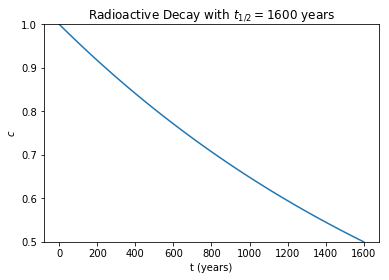

In [2]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, 1.0 * numpy.exp(-decay_constant * t))

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_ylim((0.5,1.0))
plt.show()

#### Examples:  Complex radioactive decay (or chemical system).

Chain of decays from one species to another.

$$\begin{aligned}
    \frac{\text{d} c_1}{\text{d}t} &= -\lambda_1 c_1 \\
    \frac{\text{d} c_2}{\text{d}t} &= \lambda_1 c_1 - \lambda_2 c_2 \\
    \frac{\text{d} c_2}{\text{d}t} &= \lambda_2 c_3 - \lambda_3 c_3 
\end{aligned}$$

$$\frac{\text{d} \vec{u}}{\text{d}t} = \frac{\text{d}}{\text{d}t}\begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix} = 
\begin{bmatrix} 
    -\lambda_1 & 0 & 0 \\
    \lambda_1 & -\lambda_2 & 0 \\
    0 & \lambda_2 & -\lambda_3
\end{bmatrix} \begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix}$$

$$\frac{\text{d} \vec{u}}{\text{d}t} = A \vec{u}$$

For systems of equations like this the general solution to the ODE is the matrix exponential:

$$\vec{u}(t) = \vec{u}_0 e^{A t}$$

#### Examples: Van der Pol Oscillator

$$y'' - \mu (1 - y^2) y' + y = 0~~~~~\text{with}~~~~ y(0) = y_0, ~~~y'(0) = v_0$$
 
$$\vec{u} = \begin{bmatrix} y \\ y' \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$$
   
$$\frac{\text{d}}{\text{d}t} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} u_2 \\ \mu (1 - u_1^2) u_2 - u_1 \end{bmatrix} = \vec{f}(t, \vec{u})$$

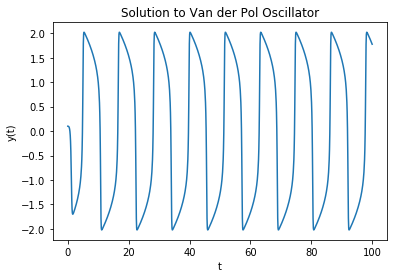

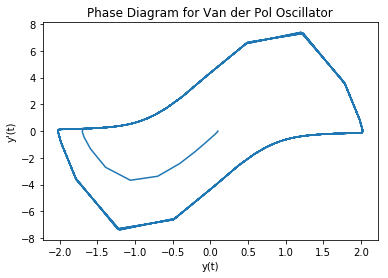

In [3]:
import scipy.integrate as integrate

def f(t, u, mu=5):
    return numpy.array([u[1], mu * (1.0 - u[0]**2) * u[1] - u[0]])

t = numpy.linspace(0.0, 100, 1000)
u = numpy.empty((2, t.shape[0]))
u[:, 0] = [0.1, 0.0]

integrator = integrate.ode(f)
integrator.set_integrator("dopri5")
integrator.set_initial_value(u[:, 0])

for (n, t_n) in enumerate(t[1:]):
    integrator.integrate(t_n)
    if not integrator.successful():
        break
    u[:, n + 1] = integrator.y
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, u[0,:])
axes.set_title("Solution to Van der Pol Oscillator")
axes.set_xlabel("t")
axes.set_ylabel("y(t)")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(u[0,:], u[1, :])
axes.set_title("Phase Diagram for Van der Pol Oscillator")
axes.set_xlabel("y(t)")
axes.set_ylabel("y'(t)")

plt.show()

#### Examples:  Heat Equation

Let's try to construct a system of ODEs that represents the heat equation
$$
    u_t = u_{xx}.
$$
If we discretize the right hand side with second order, centered differences with $m$ points we would have
$$
    \frac{\text{d}}{\text{d} t} U_i(t) = \frac{U_{i+1}(t) - 2 U_i(t) + U_{i-1}(t)}{\Delta x^2}
$$
where we now have $m$ unknown, time dependent functions to solve for.  This approach to discretizing a PDE is sometimes called a method-of-lines approach.

## Existence and Uniqueness of Solutions 

One important step before diving into the numerical methods for IVP ODE problems is to understand what the behavior of the solutions are, whether they exist, and if they might be unique.

### Linear Systems

For linear ODEs we have the generic system 
$$
    u'(t) = A(t) u + g(t)
$$
where $A$ is time-dependent matrix and $g$ a vector.  Note that linear systems always have a unique solution

If $g(t) = 0$ for all $t$ we say the ODE is *homogeneous* and the matrix $A$ is time independent (then implying that it is also *autonomous*) then the solution to this ODE is 
$$
    u(t) = u(t_0) e^{A(t - t_0)}.
$$

In the case where $g(t) \neq 0$ for all $t$ the ODE is *inhomogeneous* we can use Duhamel's principle which tells us
$$
    u(t) = u(t_0) e^{A(t-t_0)} + \int^t_{t_0} e^{A(t - \tau)} g(\tau) d\tau.
$$
We can think of the operator $e^{A(t-\tau)}$ as the solution operator for the homogeneous ODE which can map the solution at time $\tau$ to the solution at time $t$ giving this form of the solution a Green's function type property.

### Non-linear Existance and Uniqueness

#### Lipschitz Continuity

Generalizing uniqueness to non-linear ODEs requires a special type of continuity called *Lipschitz continuity*.  Consider the  ODE
$$
    u'(t) = f(u,t),  \quad \quad \quad u(t_0) = u_0,
$$
we will require a certain amount of smoothness in the right hand side function $f(u,t)$.  

We say that $f$ is Lipshitz continuous in $u$ over some domain
$$
    \Omega = \{(u,t) : |u - u_0| \leq a, t_0 \leq t \leq t_1 \}
$$
if there exists a constant $L > 0$ such that
$$
    |f(u,t) - f(u^\ast, t)| \leq L |u - u^\ast| \quad \quad \forall (u,t) ~\text{and}~ (u^\ast,t) \in \Omega.
$$

If $f(u,t)$ is differentiable with respect to $u$ in $\Omega$, i.e. the Jacobian $f_u = \partial f / \partial u$ exists, and is bounded then we can say
$$
    L = \max_{(u,t) \in \Omega} |f_u(u,t)|.
$$
We can use this bound since
$$
    f(u,t) = f(u^\ast, t) + f_u(v,t)(u-u^\ast)
$$
for some $v$ chosen to be in-between $u$ and $u^\ast$ which is effectively the Taylor series error bound and implies smoothness of $f$.

With Lipshitz continuity of $f$ we can guarantee a unique solution the IVP at least to time $T = \min(t_1, t_0 + a/S)$ where 
$$
    S = \max_{(u,t)\in\Omega} |f(u,t)|.
$$
This value $S$ is the modulus of the maximum slope that the solution $u(t)$ can obtain in $\Omega$ and guarantees that we remain in $\Omega$.

#### Example

Consider $u'(t) = (u(t))^2, u(0) = u_0 > 0$.  If we define our domain of interest as above we can compute the Lipshitz constant as
$$
    L = \max_{(u,t) \in \Omega} | 2 u | = 2 (u_0 + a)
$$
where we have used the restriction from $\Omega$ that $|u - u_0| \leq a$.  

Similarly we can compute $S$ to find
$$
    S = \max_{(u,t)\in\Omega} |f(u,t)| = (u_0 + a)^2
$$
so that we can guarantee a unique solution up until $T  = a / (u_0 + a)^2$.  Given that we can choose $a$ we can simply choose a value that maximized $T$, in this case $a = u_0$ does this and we conclude that we have a unique solution up until $T = 1 / 4 u_0$.

Since we also know the exact solution to the ODE above,
$$
    u(t) = \frac{1}{1/u_0 - t},
$$
we can see that $|u(t)| < \infty$ as long as $t \neq 1/u_0$.  Note that once we reach the pole in the denominator there is no longer a solution possible for the IVP past this point.

#### Example

Consider the IVP
$$
    u' = \sqrt{u} \quad \quad u(0) = 0.
$$

Where is this $f$ Lipshitz continuous?


<font color = "red"> 
    If we stay away from $u(0) = 0$ then we will be fine. 

Computing the derivative we find
$$
    f_u = \frac{1}{2\sqrt{u}}
$$
which goes to infinity as $u \rightarrow 0$.  We can therefore not guarantee a unique solution near the given initial condition.  In fact we know this as the ODE has two solutions
$$
    u(t) = 0 \quad \text{and} \quad u(t) = \frac{1}{4} t^2.
$$

### Systems of Equations

A similar notion for Lipschitz continuity exists in a particular norm $||\cdot||$ if there is a constant $L$ such that
$$
    ||f(u,t) - f(u^\ast,t)|| \leq L ||u - u^\ast||
$$
for all $(u,t)$ and $(u^\ast,t)$ in the domain $\Omega = \{(u,t) : ||u-u_0|| \leq a, t_0 \leq t \leq t_1 \}$.  Note that if the function $f$ is Lipschitz continuous in one norm it is continuous in any norm.

## Basic Stepping Schemes

Looking back at our work on numerical differentiation why not approximate the derivative as a finite difference:
$$
    \frac{u(t + \Delta t) - u(t)}{\Delta t} = f(t, u)
$$
We still need to decide how to evaluate the $f(t, u)$ term however.  

Lets look at this from a perspective of quadrature, take the integral of both sides:

$$\begin{aligned}
    \int^{t + \Delta t}_t \frac{\text{d} u}{\text{d}\tilde{t}} d\tilde{t} &= \int^{t + \Delta t}_t f(t, u) d\tilde{t} \\ ~ \\
u(t + \Delta t) - u(t) &= \Delta t ~f(t, u(t)) \\ ~ \\
\frac{u(t + \Delta t) - u(t)}{\Delta t} &= f(t, u(t))
\end{aligned}$$

where we have used a left-sided quadrature rule for the integral on the right.  

Introducing some notation to simplify things
$$
    t_0 = 0  \quad \quad t_1 = t_0 + \Delta t  \quad \quad t_n = t_{n-1} + \Delta t = n \Delta t + t_0
$$

$$
    U^0 = u(t_0) \quad \quad U^1 = u(t_1) \quad \quad U^n = u(t_n)
$$
we can rewrite our scheme as
$$
    \frac{U^{n+1} - U^n}{\Delta t} = f(t_n, U^n)
$$
or
$$
    U^{n+1} = U^n + \Delta t f(t_n, U^n)
$$
which is known as the *forward Euler method*.  In essence we are approximating the derivative with the value of the function at the point we are at $t_n$.

<font color = "red"> 
    subscripts are space, superscripts are time

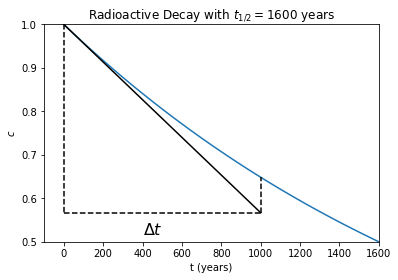

In [4]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(-decay_constant * t), label="True Solution")

# Plot Euler step
dt = 1e3
u_np = c_0 + dt * (-decay_constant * c_0)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

Note where we expect error due to the approximation and how it manifests in the example below.

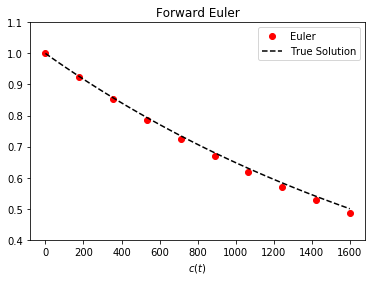

In [5]:
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(-decay_constant * t_exact)

# Implement Euler
t = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)
U[0] = c_0
for (n, t_n) in enumerate(t[:-1]):
    U[n + 1] = U[n] + delta_t * f(t_n, U[n])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U, 'or', label="Euler")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Forward Euler")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

A similar method can be derived if we consider instead using the second order accurate central difference:

$$\frac{U^{n+1} - U^{n-1}}{2\Delta t} = f(t_{n}, U^{n})$$

this method is known as the leap-frog method.  Note that the way we have written this method requires a previous function evaluation and technically is a "multi-step" method although we do not actually use the current evaluation.

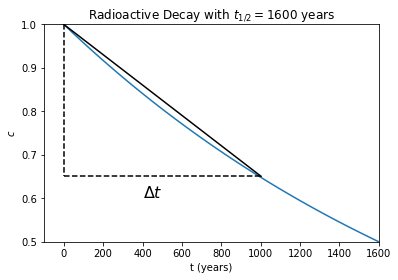

In [6]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(-decay_constant * t), label="True Solution")

# Plot Leap-Frog step
dt = 1e3
u_np = c_0 + dt * (-decay_constant * c_0 * numpy.exp(-decay_constant * dt / 2.0))
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

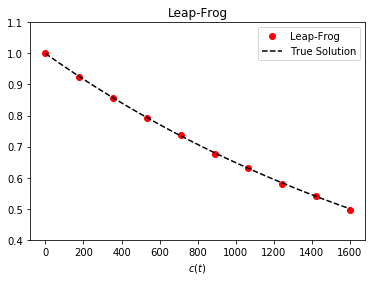

In [7]:
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(-decay_constant * t_exact)

# Implement leap-frog
t = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)
U[0] = c_0
# First evaluation use Euler to get us going
U[1] = U[0] + delta_t * f(t[0], U[0])
for n in range(1, t.shape[0] - 1):
    U[n + 1] = U[n - 1] + 2.0 * delta_t * f(t[n], U[n])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U, 'or', label="Leap-Frog")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Leap-Frog")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

Similar to forward Euler is the *backward Euler* method which evaluates the function $f$ at the updated time (right hand quadrature rule) so that
$$
    U^{n+1} = U^n + \Delta t f(t_{n+1}, U^{n+1}).
$$
Schemes where the function $f$ is evaluated at the unknown time are called *implicit methods*.

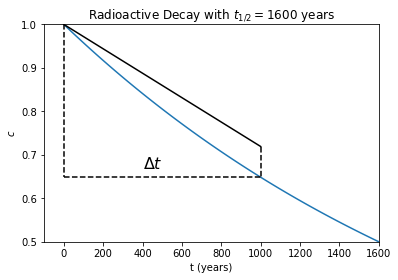

In [8]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(-decay_constant * t), label="True Solution")

# Plot Euler step
dt = 1e3
u_np = c_0 + dt * (-decay_constant * c_0 * numpy.exp(-decay_constant * dt))
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, dt), (c_0 * numpy.exp(-decay_constant * dt), c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

Write code that implements the backward Euler method
$$
    U^{n+1} = U^n + \Delta t f(t_{n+1}, U^{n+1}).
$$

Note in the following what bias the error tends to have and relate this back to the approximation.


<font color = "red"> 
$$U^{n+1} = U^n + \Delta t (- \lambda U^{n+1})$$
$$U^{n+1} = \frac{U^n}{1 + \lambda \Delta t}$$

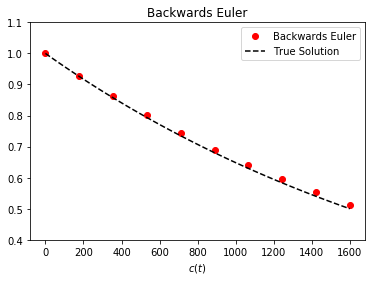

In [9]:
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(-decay_constant * t_exact)

# Implement backwards Euler
t = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)
U[0] = c_0
for n in range(0, t.shape[0] - 1):
    U[n + 1] = U[n] / (1.0 + decay_constant * delta_t)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U, 'or', label="Backwards Euler")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Backwards Euler")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

<font color = "red"> 
Barely overpredicting the value 

A modification on the Euler methods involves using the approximated midpoint to evaluate $f(t, u)$ called the midpoint method.  The scheme is
$$
    \frac{U^{n+1} - U^{n}}{\Delta t} = f\left(\frac{U^n + U^{n+1}}{2} \right).
$$
This is the simplest example of a *symplectic integrator* which has special properties for integrating Hamiltonian systems.

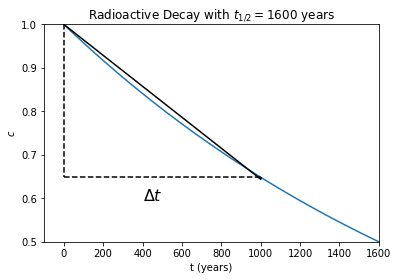

In [10]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(-decay_constant * t), label="True Solution")

# Plot Midpoint step
dt = 1e3
u_np = c_0 * (1.0 - decay_constant * dt / 2.0) / (1.0 + decay_constant * dt / 2.0)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, dt), (c_0 * numpy.exp(-decay_constant * dt), c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

Implement the midpoint method
$$
    \frac{U^{n+1} - U^{n}}{\Delta t} = f\left(\frac{U^n + U^{n+1}}{2} \right).
$$


<font color = "red"> 
$$ U^{n+1} = U^n - \lambda \frac{\Delta t}{2}(U^n + U^{n+1})$$
$$ U^{n+1}(1 + \lambda \frac{\Delta t}{2}) = U^n (1 - \lambda \frac{\Delta t}{2}) $$
$$ U^{n+1} = U^n \frac{1 - \lambda \frac{\Delta t}{2}}{1 + \lambda \frac{\Delta t}{2}}$$

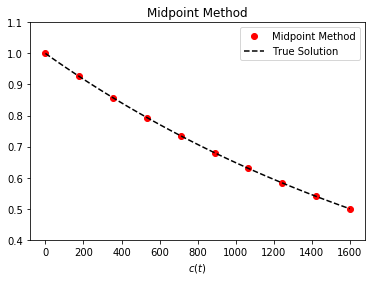

In [11]:
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(-decay_constant * t_exact)

# Implement midpoint
t = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)
U[0] = c_0
integration_constant = (1.0 - decay_constant * delta_t / 2.0) / (1.0 + decay_constant * delta_t / 2.0)
for n in range(0, t.shape[0] - 1):
    U[n + 1] = U[n] * integration_constant

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U, 'or', label="Midpoint Method")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Midpoint Method")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

Another simple implicit method is based on integration using the trapezoidal method.  The scheme is
$$
    \frac{U^{n+1} - U^{n}}{\Delta t} = \frac{1}{2} (f(U^n) + f(U^{n+1}))
$$

<font color = "red"> 
    
   $$U^{n+1} = U^n + \frac{\Delta t}{2}(-\lambda U^n - \lambda U^{n+1})$$
   $$U^{n+1}(1 + \frac{\lambda \Delta t}{2}) = U^{n}(1 - \frac{\lambda \Delta t}{2})$$

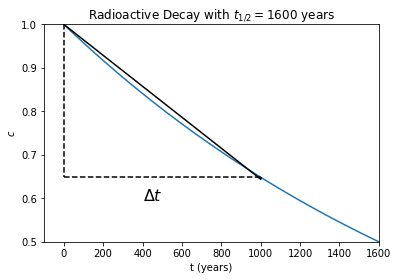

In [12]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(-decay_constant * t), label="True Solution")

# Plot Trapezoidal step
dt = 1e3
u_np = c_0 * (1.0 - decay_constant * dt / 2.0) / (1.0 + decay_constant * dt / 2.0)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, dt), (c_0 * numpy.exp(-decay_constant * dt), c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

Again implement the trapezoidal method
$$
    \frac{U^{n+1} - U^{n}}{\Delta t} = \frac{1}{2} (f(U^n) + f(U^{n+1}))
$$
What is this method equivalent to and why?  Is this generally true?

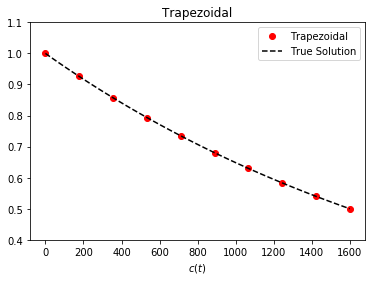

In [13]:
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0
t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(-decay_constant * t_exact)

# Implement trapezoidal method
t = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)
U[0] = c_0
integration_constant = (1.0 - decay_constant * delta_t / 2.0) / (1.0 + decay_constant * delta_t / 2.0)
for n in range(t.shape[0] - 1):
    U[n + 1] = U[n] * integration_constant

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U, 'or', label="Trapezoidal")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Trapezoidal")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

## Error Analysis

### Truncation Errors
We can define truncation errors the same as we did before where we insert the true solution of the ODE into the difference equation and use Taylor series expansions.  It is important that at this juncture we use the form of the difference that models the derivative directly as otherwise we will find something different.

Define the finite difference approximation to the derivative as $D(U^{n+1}, U^n, U^{n-1}, \ldots)$ and write the schemes above as

$$
    D(U^{n+1}, U^n, U^{n-1}, \ldots) = F(t^{n+1}, t^n, t^{n-1}, \ldots, U^{n+1}, U^n, U^{n-1}, \ldots)
$$

where $F(\cdot)$ now has some relation to evaluations of the function $f(t, u)$.  Then the local truncation error can be defined as

$$
    \tau^n = D(u(t^{n+1}), u(t^n), u(t^{n-1}), \ldots) - F(t^{n+1}, t^n, t^{n-1}, \ldots, u(t^{n+1}), u(t^n), u(t^{n-1}), \ldots)
$$

Similarly if we know
$$
    \lim_{\Delta t \rightarrow 0} \tau^n = 0
$$
then the discretized equation is considered consistent.

Order of accuracy is also defined the same way as before.  If
$$
    || \tau || \leq C \Delta t^p
$$
uniformly on $t \in [0, T]$ then the discretization is $p$th order accurate.  Note that a method is consistent if $p > 0$.

### Error Analysis of Forward Euler

We can analyze the error and convergence order of forward Euler by considering the Taylor series centered at $t_n$:
$$
    u(t) = u(t_n) + (t - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t - t_n)^2 + \mathcal{O}((t-t_n)^3)
$$

Try to compute the LTE for forward Euler's method.

Evaluating this series at $t_{n+1}$ gives
$$\begin{aligned}
u(t_{n+1}) &= u(t_n) + (t_{n+1} - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t_{n+1} - t_n)^2 + \mathcal{O}((t_{n+1}-t_n)^3)\\
&=u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3)
\end{aligned}$$

From the definition of truncation error we can use our Taylor series expression and find the truncation error to be
$$\begin{aligned}
    \tau^n &= \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - f(t_n, u(t_n)) \\
    &= \frac{1}{\Delta t} \left [u(t_n) + \Delta t ~ f(t_n, u(t_n)) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) - u(t_n) - \Delta t ~ f(t_n, u(t_n)) \right ]\\
    &= \frac{1}{\Delta t} \left [ \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right ] \\
    &= \frac{u''(t_n)}{2} \Delta t + \mathcal{O}(\Delta t^2)
\end{aligned}$$
This implies that forwar Euler is first order accurate and therefore consistent.

### Error Analysis of Leap-Frog Method

To easily analyze this method we will expand the Taylor series from before to another order and evaluate at both the needed positions:
$$
    u(t) = u(t_n) + (t - t_n) u'(t_n) + (t - t_n)^2 \frac{u''(t_n)}{2}  + (t - t_n)^3 \frac{u'''(t_n)}{6} + \mathcal{O}((t-t_n)^4)
$$
leading to 
$$\begin{aligned}
u(t_{n+1}) &= u(t_n) + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)\\
u(t_{n-1}) &= u(t_n) - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$$
See if you can compute the LTE in this case.

Plugging this into our definition of the truncation error along with the leap-frog method definition leads to
$$\begin{aligned}
    \tau^n &= \frac{u(t_{n+1}) - u(t_{n-1})}{2 \Delta t} - f(t_n, u(t_n)) \\
    &=\frac{1}{\Delta t} \left[\frac{1}{2}\left( u(t_n) + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)\right) \right . \\
    &\quad \quad\left . - \frac{1}{2} \left ( u(t_n) - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)\right ) - \Delta t~ f(t_n, u(t_n)) \right ] \\
    &= \frac{1}{\Delta t} \left [\Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^5)\right ] \\
    &= \Delta t^2 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$$
Therefore the method is second order accurate and is consistent.

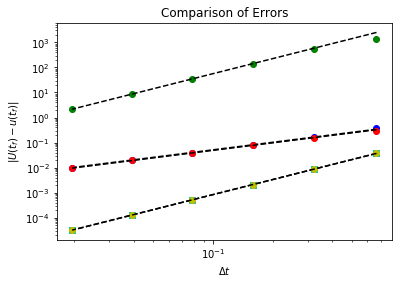

In [14]:
# Compare accuracy between Euler and Leap-Frog
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)
u_0 = 1.0

t_f = 10.0
num_steps = [2**n for n in range(4,10)]
delta_t = numpy.empty(len(num_steps))
error = numpy.empty((5, len(num_steps)))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Note that in the cases below we can instantiate this array now
    # rather than every time as none of the implicit methods require
    # the space to store the future solution
    U = numpy.empty(t.shape)
    
    # Compute ForwardEuler solution
    U[0] = u_0
    for n in range(t.shape[0] - 1):
        U[n+1] = U[n] + delta_t[i] * f(t[n], U[n])
    error[0, i] = numpy.linalg.norm(delta_t[i] * (U - u_exact(t)), ord=1)
        
    # Compute Leap-Frog
    U[0] = u_0
    U[1] = U[0] + delta_t[i] * f(t[0], U[0])
    for n in range(1, t.shape[0] - 1):
        U[n+1] = U[n-1] + 2.0 * delta_t[i] * f(t[n], U[n])
    error[1, i] = numpy.linalg.norm(delta_t[i] * (U - u_exact(t)), ord=1)
    
    # Compute Backward Euler
    U[0] = u_0
    for n in range(0, t.shape[0] - 1):
        U[n + 1] = U[n] / (1.0 + delta_t[i])
    error[2, i] = numpy.linalg.norm(delta_t[i] * (U - u_exact(t)), ord=1)
    
    # Compute mid-pointU[0] = c_0
    U[0] = u_0
    integration_constant = (1.0 - delta_t[i] / 2.0) / (1.0 + delta_t[i] / 2.0)
    for n in range(0, t.shape[0] - 1):
        U[n + 1] = U[n] * integration_constant
    error[3, i] = numpy.linalg.norm(delta_t[i] * (U - u_exact(t)), ord=1)
    
    # Compute trapezoidal
    U[0] = u_0
    integration_constant = (1.0 - delta_t[i] / 2.0) / (1.0 + delta_t[i] / 2.0)
    for n in range(t.shape[0] - 1):
        U[n + 1] = U[n] * integration_constant
    error[4, i] = numpy.linalg.norm(delta_t[i] * (U - u_exact(t)), ord=1)
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
style = ['bo', 'go', 'ro', 'cs', 'yo']
label = ['Forward Euler', "Leap-Frog", "Backward Euler", "Mid-Point", "Trapezoidal"]
order = [1, 2, 1, 2, 2]

for k in range(5):
    axes.loglog(delta_t, error[k, :], style[k], label=label[k])
    axes.loglog(delta_t, order_C(delta_t[2], error[k, 2], order[k]) * delta_t**order[k], 'k--')

# axes.legend(loc=2)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

### One-Step Errors

There is another definition of local truncation error sometimes used in ODE numerical methods called the *one-step error* which is slightly different than our local truncation error definition.  Our definition uses the direct discretization of the derivatives to find the LTE where as this alternative bases the error on a form that looks like it is updating the previous value.  

As an example consider the leap-frog method, the LTE we found before was based on
$$
    \frac{U_{n+1} - U_{n-1}}{2 \Delta t} = f(U_n)
$$
leading us to a second order LTE.  

For the one-step error we consider instead 
$$
    U_{n+1} = U_{n-1} + 2 \Delta t f(U_n)
$$
which leads to the one-step error $\mathcal{O}(\Delta t^3)$ instead!

$$\begin{aligned}
    \mathcal{L}^n &= u(t_{n+1}) - u(t_{n-1}) - 2 \Delta t f(u(t_n)) \\
    &= \frac{1}{3} \Delta t^3 u'''(t_n) + \mathcal{O}(\Delta t^5) \\
    &= 2 ~\Delta t ~\tau^n.
\end{aligned}$$

This one-step error is suggestively named to indicate that perhaps this is the error for one time step where as the global error may be higher.  To remain consistent with our previous discussion of convergences we will continue to use our previous definition of the LTE.  We will show that with the appropriate definition of stability and a $p$ order LTE we can expect a $p$th order global error.  In general for a $p+1$th order one-step error the global error will be $p$th order.

## Taylor Series Methods

A **Taylor series method** can be derived by direct substitution of the right-hand-side function $f(t, u)$ and it's appropriate derivatives into the Taylor series expansion for $u(t_{n+1})$.  For a $p$th order method we would look at the Taylor series up to that order and replace all the derivatives of $u$ with derivatives of $f$ instead.  

For the general case we have
$$\begin{aligned}
    u(t_{n+1}) = u(t_n) + \Delta t u'(t_n) + \frac{\Delta t^2}{2} u''(t_n) + \frac{\Delta t^3}{6} u'''(t_n) + \cdots + \frac{\Delta t^p}{p!} u^{(p)}(t_n)
\end{aligned}$$
which contains derivatives of $u$ up to $p$th order.  We then replace these derivatives with the appropriate derivative of $f$ which will always be one less than the derivative of $u$ (due to the original ODE)
$$
    u^{(p)}(t_n) = f^{(p-1)}(t_n, u(t_n))
$$
leading to the method
$$
    u(t_{n+1}) = u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{\Delta t^2}{2} f'(t_n, u(t_n)) + \frac{\Delta t^3}{6} f''(t_n, u(t_n)) + \cdots + \frac{\Delta t^p}{p!} f^{(p-1)}(t_n, u(t_n)).
$$

The drawback to these methods is that we have to derive a new one each time we have a new $f$ and we also need $p-1$ derivatives of $f$.

### 2nd Order Taylor Series Method

We want terms up to second order so we need to take the derivative of $u' = f(t, u)$ once to find $u'' = f'(t, u)$.  See if you can derive the method.

\begin{align*}
    u(t_{n+1}) &= u(t_n) + \Delta t u'(t_n) + \frac{\Delta t^2}{2} u''(t_n) \\
    &=u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{\Delta t^2}{2} f'(t_n, u(t_n)) \quad \text{or} \\
    U^{n+1} &= U^n + \Delta t f(t_n, U^n) + \frac{\Delta t^2}{2} f'(t_n, U^n).
\end{align*}

## Runge-Kutta Methods

One way to derive higher-order ODE solvers is by computing intermediate stages.  These are not *multi-step* methods as they still only require information from the current time step but they raise the order of accuracy by adding *stages*.  These types of methods are called **Runge-Kutta** methods.

### Example:  Two-stage Runge-Kutta Methods

The basic idea behind the simplest of the Runge-Kutta methods is to approximate the solution at $t_n + \Delta t / 2$ via Euler's method and use this in the function evaluation for the final update.
$$\begin{aligned}
    U^* &= U^n + \frac{1}{2} \Delta t f(U^n) \\
    U^{n+1} &= U^n + \Delta t f(U^*) = U^n + \Delta t f(U^n + \frac{1}{2} \Delta t f(U^n))
\end{aligned}$$

The truncation error can be computed similarly to how we did so before but we do need to figure out how to compute the derivative inside of the function.  Note that due to 
$$
    f(u(t_n)) = u'(t_n)
$$ 
that differentiating this leads to 
$$
    f'(u(t_n)) u'(t_n) = u''(t_n)
$$
leading to

$$\begin{aligned}
    f\left(u(t_n) + \frac{1}{2} \Delta t f(u(t_n)) \right ) &= f\left(u(t_n) +\frac{1}{2} \Delta t u'(t_n) \right ) \\
    &= f(u(t_n)) + \frac{1}{2} \Delta t u'(t_n) f'(u(t_n)) + \frac{1}{8} \Delta t^2 (u'(t_n))^2 f''(u(t_n)) + \mathcal{O}(\Delta t^3) \\
    &=u'(t_n) + \frac{1}{2} \Delta t u''(t_n) + \mathcal{O}(\Delta t^2)
\end{aligned}$$

Going back to the truncation error we have
$$\begin{aligned}
    \tau^n &= \frac{1}{\Delta t} \left[u(t_n) + \Delta t f\left(u(t_n) + \frac{1}{2} \Delta t f(u(t_n))\right) - \left(u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right ) \right] \\
    &=\frac{1}{\Delta t} \left[\Delta t u'(t_n) + \frac{1}{2} \Delta t^2 u''(t_n) + \mathcal{O}(\Delta t^3) - \Delta t u'(t_n) - \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right] \\
    &= \mathcal{O}(\Delta t^2)
\end{aligned}$$
so this method is second order accurate.

### Example:  4-stage Runge-Kutta Method

$\begin{aligned}
    Y_1 &= U^n \\
    Y_2 &= U^n + \frac{1}{2} \Delta t f(Y_1, t_n) \\
    Y_3 &= U^n + \frac{1}{2} \Delta t f(Y_2, t_n + \Delta t / 2) \\
    Y_4 &= U^n + \Delta t f(Y_3, t_n + \Delta t / 2) \\
    U^{n+1} &= U^n + \frac{\Delta t}{6} \left [f(Y_1, t_n) + 2 f(Y_2, t_n + \Delta t / 2) + 2 f(Y_3, t_n + \Delta t/2) + f(Y_4, t_n + \Delta t) \right ]
\end{aligned}$


<font color = "red">
    This is order 5 method.

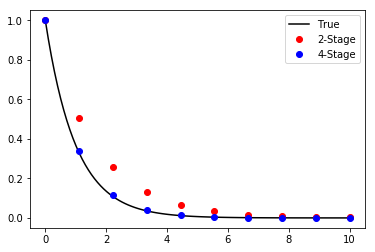

In [15]:
# Implement and compare the two-stage and 4-stage Runge-Kutta methods
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 10
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]

# RK 2
U_2 = numpy.empty(t.shape)
U_2[0] = 1.0
for (n, t_n) in enumerate(t[1:]):
    U_2[n+1] = U_2[n] + 0.5 * delta_t * f(t_n, U_2[n])
    U_2[n+1] = U_2[n] + delta_t * f(t_n + 0.5 * delta_t, U_2[n+1])

# RK4
U_4 = numpy.empty(t.shape)
U_4[0] = 1.0
for (n, t_n) in enumerate(t[1:]):
    y_1 = U_4[n]
    y_2 = U_4[n] + 0.5 * delta_t * f(t_n, y_1)
    y_3 = U_4[n] + 0.5 * delta_t * f(t_n + 0.5 * delta_t, y_2)
    y_4 = U_4[n] + delta_t * f(t_n + 0.5 * delta_t, y_3)
    U_4[n+1] = U_4[n] + delta_t / 6.0 * (f(t_n, y_1) + 2.0 * f(t_n + 0.5 * delta_t, y_2) + 2.0 * f(t_n + 0.5 * delta_t, y_3) + f(t_n + delta_t, y_4))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, U_2, 'ro', label="2-Stage")
axes.plot(t, U_4, 'bo', label="4-Stage")
axes.legend(loc=1)

plt.show()

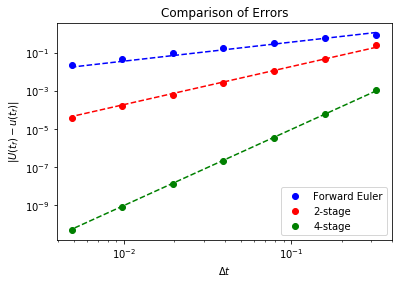

In [16]:
# Compare accuracy between Euler and RK
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)

t_f = 10.0
num_steps = [2**n for n in range(5,12)]
delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_2 = numpy.empty(len(num_steps))
error_4 = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Compute Euler solution
    U_euler = numpy.empty(t.shape)
    U_euler[0] = 1.0
    for (n, t_n) in enumerate(t[1:]):
        U_euler[n+1] = U_euler[n] + delta_t[i] * f(t_n, U_euler[n])
        
    # Compute 2 and 4-stage
    U_2 = numpy.empty(t.shape)
    U_4 = numpy.empty(t.shape)
    U_2[0] = 1.0
    U_4[0] = 1.0
    for (n, t_n) in enumerate(t[1:]):
        U_2[n+1] = U_2[n] + 0.5 * delta_t[i] * f(t_n, U_2[n])
        U_2[n+1] = U_2[n] + delta_t[i] * f(t_n, U_2[n+1])
        y_1 = U_4[n]
        y_2 = U_4[n] + 0.5 * delta_t[i] * f(t_n, y_1)
        y_3 = U_4[n] + 0.5 * delta_t[i] * f(t_n + 0.5 * delta_t[i], y_2)
        y_4 = U_4[n] + delta_t[i] * f(t_n + 0.5 * delta_t[i], y_3)
        U_4[n+1] = U_4[n] + delta_t[i] / 6.0 * (f(t_n, y_1) + 2.0 * f(t_n + 0.5 * delta_t[i], y_2) + 2.0 * f(t_n + 0.5 * delta_t[i], y_3) + f(t_n + delta_t[i], y_4))
        
    # Compute error for each
    error_euler[i] = numpy.abs(U_euler[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    error_2[i] = numpy.abs(U_2[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    error_4[i] = numpy.abs(U_4[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_euler, 'bo', label='Forward Euler')
axes.loglog(delta_t, error_2, 'ro', label='2-stage')
axes.loglog(delta_t, error_4, 'go', label="4-stage")

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 1.0) * delta_t**1.0, '--b')
axes.loglog(delta_t, order_C(delta_t[1], error_2[1], 2.0) * delta_t**2.0, '--r')
axes.loglog(delta_t, order_C(delta_t[1], error_4[1], 4.0) * delta_t**4.0, '--g')

axes.legend(loc=4)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

## Linear Multi-Step Methods

Multi-step methods (as introduced via the leap-frog method) are ODE methods that require multiple time step evaluations to work.  Some of the advanatages of using a multi-step method rather than one-step method included

 - Taylor series methods require differentiating the given equation which can be cumbersome and difficult to impelent
 - One-step methods at higher order often require the evaluation of the function $f$ many times
 
Disadvantages

 - Methods are not self-starting, i.e. they require other methods to find the initial values
 - The time step $\Delta t$ in one-step methods can be changed at any time while multi-step methods this is much more complex
 

### General Linear Multi-Step Methods

All linear multi-step methods can be written as the linear combination of past, present and future solutions:

$$
    \sum^r_{j=0} \alpha_j U^{n+j} = \Delta t \sum^r_{j=0} \beta_j f(U^{n+j}, t_{n+j})
$$

If $\beta_r = 0$ then the method is explicit (only requires previous time steps).  Note that the coefficients are not unique as we can multiply both sides by a constant.  In practice a normalization of $\alpha_r = 1$ is used.

#### Example: Adams Methods

$$
    U^{n+r} = U^{n+r-1} + \Delta t \sum^r_{j=0} \beta_j f(U^{n+j})
$$

All these methods have $\alpha_r = 1$, $\alpha_{r-1} = -1$ and $\alpha_j=0$ for $j < r - 1$ leaving the method to be specified by how the evaluations of $f$ is done determining the $\beta_j$.

### Adams-Bashforth Methods
The **Adams-Bashforth** methods are explicit solvers that maximize the order of accuracy given a number of steps $r$.  This is accomplished by looking at the Taylor series and picking the coefficients $\beta_j$ to elliminate as many terms in the Taylor series as possible.
$$\begin{aligned}
    \text{1-step:} & & U_{n+1} &= U_n +\Delta t f(U_n) \\
    \text{2-step:} & & U_{n+2} &= U_{n+1} + \frac{\Delta t}{2} (-f(U_n) + 3 f(U_{n+1})) \\
    \text{3-step:} & & U_{n+3} &= U_{n+2} + \frac{\Delta t}{12} (5 f(U_n) - 16 f(U_{n+1}) + 23 f(U_{n+2})) \\
    \text{4-step:} & & U_{n+4} &= U_{n+3} + \frac{\Delta t}{24} (-9 f(U_n) + 37 f(U_{n+1}) -59 f(U_{n+2}) + 55 f(U_{n+3}))
\end{aligned}$$

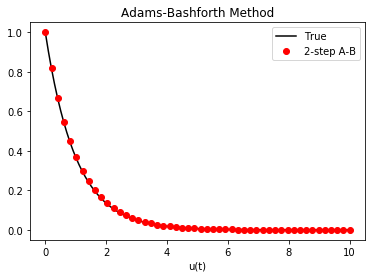

In [17]:
# Use 2-step Adams-Bashforth to compute solution
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 50
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)

# Use RK-2 to start the method
U[0] = 1.0
U[1] = U[0] + 0.5 * delta_t * f(t[0], U[0])
U[1] = U[0] + delta_t * f(t[0], U[1])
for n in range(0,len(t)-2):
    U[n+2] = U[n + 1] + delta_t / 2.0 * (-f(t[n], U[n]) + 3.0 * f(t[n+1], U[n+1]))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, U, 'ro', label="2-step A-B")

axes.set_title("Adams-Bashforth Method")
axes.set_xlabel("t")
axes.set_xlabel("u(t)")
axes.legend(loc=1)

plt.show()

### Adams-Moulton Methods
The **Adams-Moulton** methods are the implicit versions of the Adams-Bashforth methods.  Since this gives one additional parameter to use $\beta_r$ these methods are generally one order of accuracy greater than their counterparts.
$$\begin{aligned}
    \text{1-step:} &  & U_{n+1} &= U_n + \frac{\Delta t}{2} (f(U_n) + f(U_{n+1})) \\
    \text{2-step:} &  & U_{n+2} &= U_{n+1} + \frac{\Delta t}{12} (-f(U_n) + 8f(U_{n+1}) + 5f(U_{n+2})) \\
    \text{3-step:} &  & U_{n+3} &= U_{n+2} + \frac{\Delta t}{24} (f(U_n) - 5f(U_{n+1}) + 19f(U_{n+2}) + 9f(U_{n+3})) \\
    \text{4-step:} &  & U_{n+4} &= U_{n+3} + \frac{\Delta t}{720}(-19 f(U_n) + 106 f(U_{n+1}) -264 f(U_{n+2}) + 646 f(U_{n+3}) + 251 f(U_{n+4}))
\end{aligned}$$

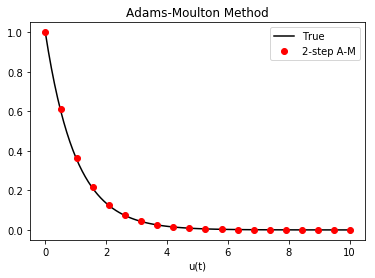

In [18]:
# Use 2-step Adams-Moulton to compute solution
# u' = - decay u
decay_constant = 1.0
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 20
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)
U[0] = 1.0
U[1] = U[0] + 0.5 * delta_t * f(t[0], U[0])
U[1] = U[0] + delta_t * f(t[0], U[1])    
integration_constant = 1.0 / (1.0 + 5.0 * decay_constant * delta_t / 12.0)
for n in range(t.shape[0] - 2):
    U[n+2] = (U[n+1] + decay_constant * delta_t / 12.0 * (U[n] - 8.0 * U[n+1])) * integration_constant

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, U, 'ro', label="2-step A-M")

axes.set_title("Adams-Moulton Method")
axes.set_xlabel("t")
axes.set_xlabel("u(t)")
axes.legend(loc=1)

plt.show()

### Truncation Error for Multi-Step Methods

We can again find the truncation error in general for linear multi-step methods:

$$\begin{aligned}
    \tau^n &= \frac{1}{\Delta t} \left [\sum^r_{j=0} \alpha_j u(t_{n+j}) - \Delta t \sum^r_{j=0} \beta_j f(t_{n+j}, u(t_{n+j})) \right ]
\end{aligned}$$

Using the general expansion and evalution of the Taylor series about $t_n$ we have
$$\begin{aligned}
    u(t_{n+j}) &= u(t_n) + j \Delta t u'(t_n) + \frac{1}{2} (j \Delta t)^2 u''(t_n) + \mathcal{O}(\Delta t^3) \\
    u'(t_{n+j}) &= u'(t_n) + j \Delta t u''(t_n) + \frac{1}{2} (j \Delta t)^2 u'''(t_n) + \mathcal{O}(\Delta t^3)
\end{aligned}$$
leading to
$$\begin{aligned}
\tau^n &= \frac{1}{\Delta t}\left( \sum^r_{j=0} \alpha_j\right) u(t_{n}) + \left(\sum^r_{j=0} (j\alpha_j - \beta_j)\right) u'(t_n) + \Delta t \left(\sum^r_{j=0} \left (\frac{1}{2}j^2 \alpha_j - j \beta_j \right) \right) u''(t_n) \\
&\quad \quad + \cdots + \Delta t^{q - 1} \left (\frac{1}{q!} \left(j^q \alpha_j - \frac{1}{(q-1)!} j^{q-1} \beta_j \right) \right) u^{(q)}(t_n) + \cdots
\end{aligned}$$

The method is *consistent* if the first two terms of the expansion vanish, i.e. 
$$
    \sum^r_{j=0} \alpha_j = 0
$$ 
and 
$$
    \sum^r_{j=0} j \alpha_j = \sum^r_{j=0} \beta_j.
$$

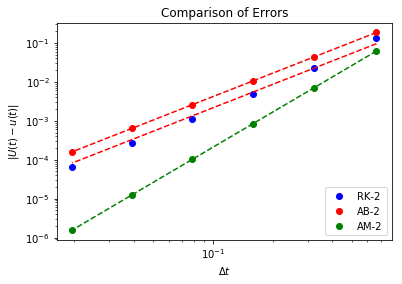

In [19]:
# Compare accuracy between RK-2, AB-2 and AM-2
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)

t_f = 10.0
num_steps = [2**n for n in range(4,10)]
delta_t = numpy.empty(len(num_steps))
error_rk = numpy.empty(len(num_steps))
error_ab = numpy.empty(len(num_steps))
error_am = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
        
    # Compute RK2
    U_rk = numpy.empty(t.shape)
    U_rk[0] = 1.0
    for n in range(t.shape[0]-1):
        U_rk[n+1] = U_rk[n] + 0.5 * delta_t[i] * f(t[n], U_rk[n])
        U_rk[n+1] = U_rk[n] + delta_t[i] * f(t[n], U_rk[n+1])
        
    # Compute Adams-Bashforth 2-stage
    U_ab = numpy.empty(t.shape)
    U_ab[:2] = U_rk[:2]
    for n in range(t.shape[0] - 2):
        U_ab[n+2] = U_ab[n + 1] + delta_t[i] / 2.0 * (-f(t[n], U_ab[n]) + 3.0 * f(t[n+1], U_ab[n+1]))
    
    # Compute Adama-Moulton 2-stage
    U_am = numpy.empty(t.shape)
    U_am[:2] = U_rk[:2]
    decay_constant = 1.0
    integration_constant = 1.0 / (1.0 + 5.0 * decay_constant * delta_t[i] / 12.0)
    for n in range(t.shape[0] - 2):
        U_am[n+2] = (U_am[n+1] + decay_constant * delta_t[i] / 12.0 * (U_am[n] - 8.0 * U_am[n+1])) * integration_constant
        
    # Compute error for each
    error_rk[i] = numpy.linalg.norm(delta_t[i] * (U_rk - u_exact(t)), ord=1)
    error_ab[i] = numpy.linalg.norm(delta_t[i] * (U_ab - u_exact(t)), ord=1)
    error_am[i] = numpy.linalg.norm(delta_t[i] * (U_am - u_exact(t)), ord=1)
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_rk, 'bo', label='RK-2')
axes.loglog(delta_t, error_ab, 'ro', label='AB-2')
axes.loglog(delta_t, error_am, 'go', label="AM-2")

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_rk[1], 2.0) * delta_t**2.0, '--r')
axes.loglog(delta_t, order_C(delta_t[1], error_ab[1], 2.0) * delta_t**2.0, '--r')
axes.loglog(delta_t, order_C(delta_t[1], error_am[1], 3.0) * delta_t**3.0, '--g')

axes.legend(loc=4)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t) - u(t)|$")

plt.show()

### Predictor-Corrector Methods

One way to simplify the Adams-Moulton methods so that implicit evaluations are not needed is by estimating the required implicit function evaluations with an explicit method.  These are often called **predictor-corrector** methods as the explicit method provides a *prediction* of what the solution might be and the not explicit *corrector* step works to make that estimate more accurate.

#### Example: One-Step Adams-Bashforth-Moulton

Use the One-step Adams-Bashforth method to predict the value of $U^{n+1}$ and then use the Adams-Moulton method to correct that value:

$\hat{U}^{n+1} = U^n + \Delta t f(U^n)$

$U^{n+1} = U^n + \frac{1}{2} \Delta t (f(U^n) + f(\hat{U}^{n+1})$

This method is second order accurate. 

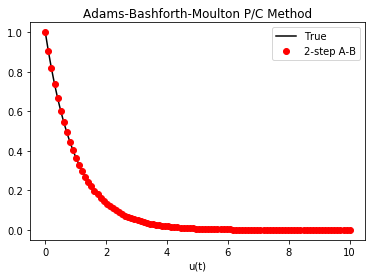

In [20]:
# One-step Adams-Bashforth-Moulton
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 100
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)

U[0] = 1.0
for n in range(t.shape[0] - 1):
    U[n+1] = U[n] + delta_t * f(t[n], U[n])
    U[n+1] = U[n] + 0.5 * delta_t * (f(t[n], U[n]) + f(t[n+1], U[n+1]))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, U, 'ro', label="2-step A-B")

axes.set_title("Adams-Bashforth-Moulton P/C Method")
axes.set_xlabel("t")
axes.set_xlabel("u(t)")
axes.legend(loc=1)

plt.show()

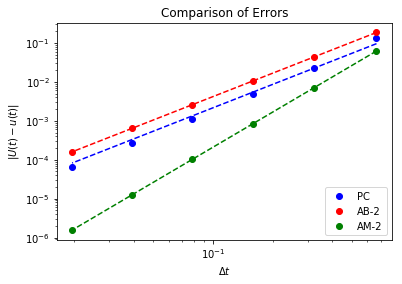

In [21]:
# Compare accuracy between RK-2, AB-2 and AM-2
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)

t_f = 10.0
num_steps = [2**n for n in range(4,10)]
delta_t = numpy.empty(len(num_steps))
error_ab = numpy.empty(len(num_steps))
error_am = numpy.empty(len(num_steps))
error_pc = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # RK-2 bootstrap for AB and AM
    U_rk = numpy.empty(2)
    U_rk[0] = 1.0
    U_rk[1] = U_rk[0] + 0.5 * delta_t[i] * f(t[0], U_rk[0])
    U_rk[1] = U_rk[0] + delta_t[i] * f(t[0], U_rk[1])
        
    # Compute Adams-Bashforth 2-stage
    U_ab = numpy.empty(t.shape)
    U_ab[:2] = U_rk[:2]
    for n in range(t.shape[0] - 2):
        U_ab[n+2] = U_ab[n + 1] + delta_t[i] / 2.0 * (-f(t[n], U_ab[n]) + 3.0 * f(t[n+1], U_ab[n+1]))
    
    # Compute Adams-Moulton 2-stage
    U_am = numpy.empty(t.shape)
    U_am[:2] = U_ab[:2]
    decay_constant = 1.0
    integration_constant = 1.0 / (1.0 + 5.0 * decay_constant * delta_t[i] / 12.0)
    for n in range(t.shape[0] - 2):
        U_am[n+2] = (U_am[n+1] + decay_constant * delta_t[i] / 12.0 * (U_am[n] - 8.0 * U_am[n+1])) * integration_constant
        
    # Compute Adams-Bashforth-Moulton
    U_pc = numpy.empty(t.shape)
    U_pc[0] = 1.0
    for n in range(t.shape[0] - 1):
        U_pc[n+1] = U_pc[n] + delta_t[i] * f(t[n], U_pc[n])
        U_pc[n+1] = U_pc[n] + 0.5 * delta_t[i] * (f(t[n], U_pc[n]) + f(t[n+1], U_pc[n+1]))
        
    # Compute error for each
    error_ab[i] = numpy.linalg.norm(delta_t[i] * (U_ab - u_exact(t)), ord=1)
    error_am[i] = numpy.linalg.norm(delta_t[i] * (U_am - u_exact(t)), ord=1)
    error_pc[i] = numpy.linalg.norm(delta_t[i] * (U_pc - u_exact(t)), ord=1)
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_pc, 'bo', label='PC')
axes.loglog(delta_t, error_ab, 'ro', label='AB-2')
axes.loglog(delta_t, error_am, 'go', label="AM-2")

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_pc[1], 2.0) * delta_t**2.0, '--b')
axes.loglog(delta_t, order_C(delta_t[1], error_ab[1], 2.0) * delta_t**2.0, '--r')
axes.loglog(delta_t, order_C(delta_t[1], error_am[1], 3.0) * delta_t**3.0, '--g')

axes.legend(loc=4)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t) - u(t)|$")

plt.show()